In [1]:
from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

### Load Dataset

In [30]:
df=pd.read_csv('cardio_train.csv',sep=';')

In [31]:
df.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

### Dataset Information

In [5]:
df.shape

(70000, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [7]:
df.describe()

id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      0.680250      0.572270      0.283484   
min     -150.000000    -70.000000      1.000000      1.000000      0.000000   
25%      120.000000     80.000000      1.000000      1.000000      0.000000   
50%      120.000000     80.000000      1.000000      1.000000      0.000000   
75%      140.000000     90.000000      2.000000      1.000000      0.000000   
max    16020.000000  11000.000000      3.000000      3.000000      1.000000   

               alco        active        cardio  
count  70000.000000  70000.000000  70000.000000  
mean       0.053771      0.803729      0.499700  
std        0.225568      0.397179      0.500003  
min        0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000  
50%        0.000000      1.000000      0.000000  
75%        0.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

### Cleaning Data

In [32]:
#Rename columns for better understanding
df = df.rename(columns={'ap_hi': 'systolic_b_pressure'})
df = df.rename(columns={'ap_lo': 'diastolic_b_pressure'})
df = df.rename(columns={'gluc': 'glucose'})
df = df.rename(columns={'alco': 'alcohol'})
df = df.rename(columns={'active': 'physically_active'})
df = df.rename(columns={'cardio': 'cardio_disease'})

In [9]:
df.head(3)

id    age  gender  height  weight  systolic_b_pressure  \
0   0  18393       2     168    62.0                  110   
1   1  20228       1     156    85.0                  140   
2   2  18857       1     165    64.0                  130   

   diastolic_b_pressure  cholesterol  glucose  smoke  alcohol  \
0                    80            1        1      0        0   
1                    90            3        1      0        0   
2                    70            3        1      0        0   

   physically_active  cardio_disease  
0                  1               0  
1                  1               1  
2                  0               1

In [33]:
#Converting age from days to years
df['age'] = df['age'] / 365.25
df['age'] = df['age'].apply(lambda x: math.ceil(x)).astype(int)

In [34]:
df.age

0        51
1        56
2        52
3        49
4        48
         ..
69995    53
69996    62
69997    53
69998    62
69999    57
Name: age, Length: 70000, dtype: int64

In [35]:
#Creating a BMI column
df["bmi"]=df["weight"]/((df["height"]/100)**2)
df.head()

id  age  gender  height  weight  systolic_b_pressure  diastolic_b_pressure  \
0   0   51       2     168    62.0                  110                    80   
1   1   56       1     156    85.0                  140                    90   
2   2   52       1     165    64.0                  130                    70   
3   3   49       2     169    82.0                  150                   100   
4   4   48       1     156    56.0                  100                    60   

   cholesterol  glucose  smoke  alcohol  physically_active  cardio_disease  \
0            1        1      0        0                  1               0   
1            3        1      0        0                  1               1   
2            3        1      0        0                  0               1   
3            1        1      0        0                  1               1   
4            1        1      0        0                  0               0   

         bmi  
0  21.967120  
1  34.927679  
2  23.507805  
3  28.710479  
4  23.011177

In [36]:
#Checking if there are null values
df.isnull().sum()

id                      0
age                     0
gender                  0
height                  0
weight                  0
systolic_b_pressure     0
diastolic_b_pressure    0
cholesterol             0
glucose                 0
smoke                   0
alcohol                 0
physically_active       0
cardio_disease          0
bmi                     0
dtype: int64

### EDA

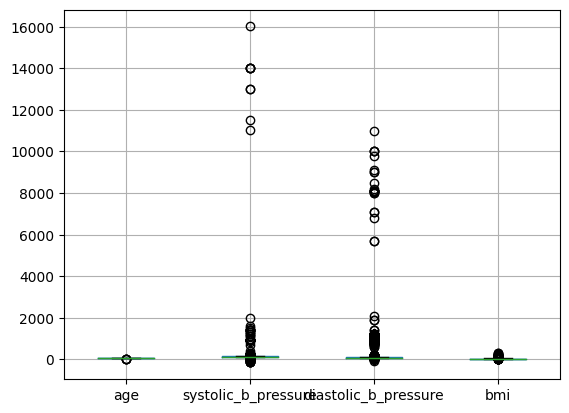

In [37]:
#Checking for outliers
df[["age","systolic_b_pressure","diastolic_b_pressure","bmi"]].boxplot()
plt.show()

In [38]:
data=df[["age","systolic_b_pressure","diastolic_b_pressure","bmi"]]

In [39]:
Q1=data.quantile(0.25)
Q3=data.quantile(0.75)

IQR=Q3-Q1
IQR

age                     10.000000
systolic_b_pressure     20.000000
diastolic_b_pressure    10.000000
bmi                      6.347107
dtype: float64

### Inference
To remove the outliers, the interquartile range is calculated, use the third (Q3) and first (Q1) quartiles. The interval between the data distribution's 25th and 75th percentiles is represented by the IQR, a statistical dispersion measure.

In [40]:
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
outliers

0        False
1        False
2        False
3        False
4         True
         ...  
69995    False
69996     True
69997     True
69998    False
69999    False
Length: 70000, dtype: bool

In [41]:
df=df[~outliers]

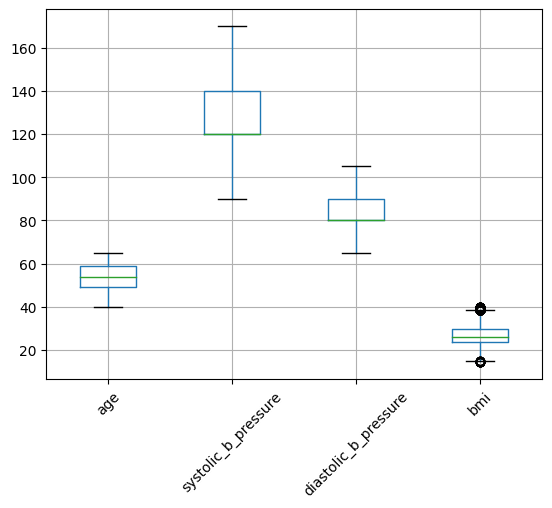

In [42]:
df[["age","systolic_b_pressure","diastolic_b_pressure","bmi"]].boxplot()
plt.xticks(rotation=45)
plt.show()

In [20]:
df[["age","systolic_b_pressure","diastolic_b_pressure","bmi"]].describe()

age  systolic_b_pressure  diastolic_b_pressure           bmi
count  62745.000000         62745.000000          62745.000000  62745.000000
mean      53.843812           126.404319             81.689537     27.034727
std        6.741825            14.296927              7.673500      4.406103
min       40.000000            90.000000             65.000000     14.479500
25%       49.000000           120.000000             80.000000     23.875115
50%       54.000000           120.000000             80.000000     26.222222
75%       59.000000           140.000000             90.000000     29.757585
max       65.000000           170.000000            105.000000     39.736121

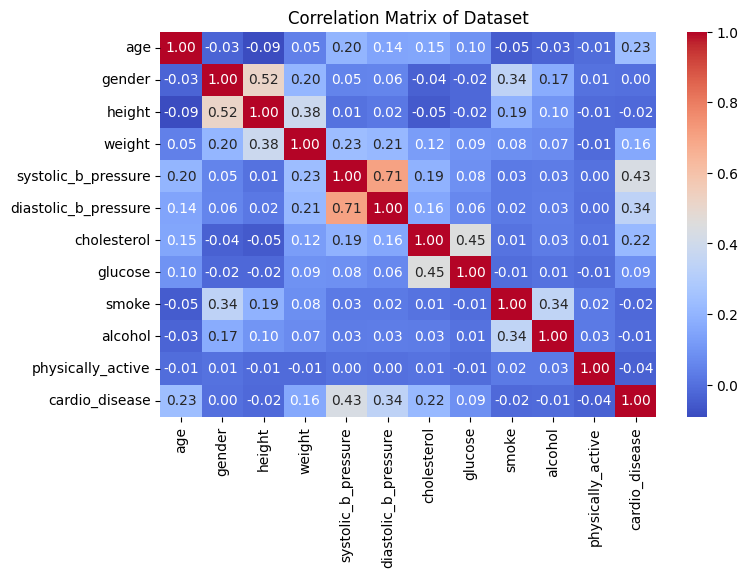

In [21]:
#Correlation Matrix
corr_matrix = df[['age', 'gender', 'height', 'weight', 'systolic_b_pressure',
       'diastolic_b_pressure', 'cholesterol', 'glucose', 'smoke', 'alcohol',
       'physically_active', 'cardio_disease']].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Dataset');
plt.show()

### Inference
From the generated heatmap, it can be observed that certain variables exhibit notable correlations. For example, there is a moderate positive correlation between systolic and diastolic blood pressure, indicating that individuals with higher systolic blood pressure tend to have higher diastolic blood pressure as well. Furthermore, there are relatively weak correlations between most of the other variables, suggesting that they are largely independent of each other. Positive correlations displayed in warmer tones (like red) and negative correlations displayed in cooler tones (like blue), this visualisation makes it easy to quickly identify relationships between variables.



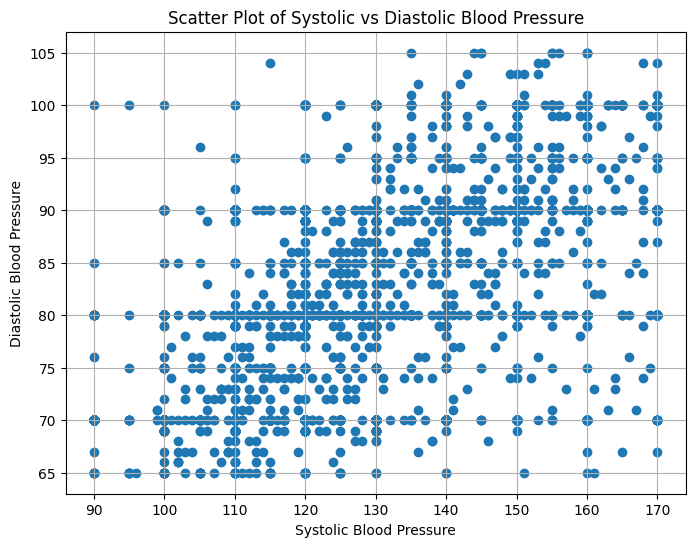

In [22]:
#Scatter plot between "Systolic_b_Pressure" and "diastolic_b_Pressure"
plt.figure(figsize=(8, 6))
plt.scatter(df['systolic_b_pressure'], df['diastolic_b_pressure'])
plt.title('Scatter Plot of Systolic vs Diastolic Blood Pressure')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Diastolic Blood Pressure')
plt.grid(True)
plt.show()

### Inference
The systolic blood pressure (x-axis) and diastolic blood pressure (y-axis) are shown in a scatter plot. An individual's systolic and diastolic blood pressure readings are represented by each point on the plot. We can visually examine the relationship between these two variables and determine whether a pattern or trend is apparent using the scatter plot. The plot reveals a clear positive correlation between the two blood pressure measurements. This means that individuals with higher systolic blood pressure values tend to also have higher diastolic blood pressure values, and vice versa.

In [23]:
#Countplot to show number of people have cardio disease
df["cardio_disease"].value_counts()

cardio_disease
0    31783
1    30962
Name: count, dtype: int64

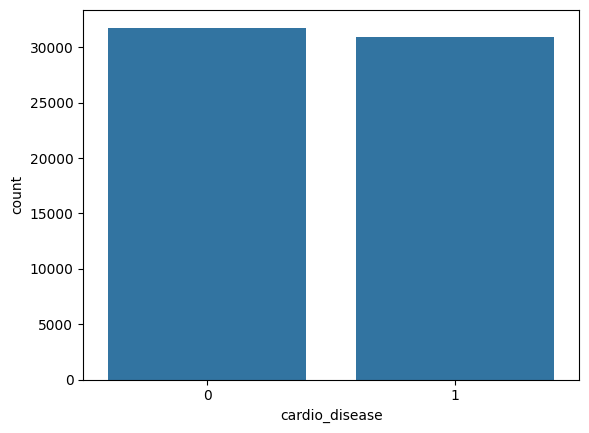

In [24]:
sns.countplot(data = df, x = 'cardio_disease')
plt.show()

### Inference
This distribution is represented graphically by the countplot, which shows bars for each category ("0" denoting no cardiovascular disease and "1" denoting the disease's presence). For every group, the close count values are effectively displayed by the bar heights. The incidence of cardiovascular disease in the dataset can be better understood and patterns can be identified with the help of this graphic depiction.



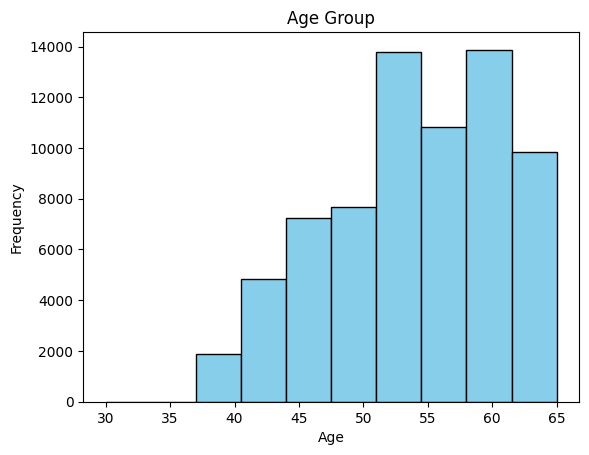

In [25]:
#Histogram plot to show count of people in a particular age
plt.hist(data['age'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Group')
plt.show()

### Inference
The histogram plot depicts the distribution of people across various age groups. The x-axis represents age, and the y-axis represents the frequency or count of people within each age group. The bins, colored skyblue in the image, partition the age range into ten equal intervals. The height of each bar corresponds to the number of people within that particular age group.
The tallest bar in the image represents an individual between the ages of 40 and 45, suggesting that the majority of the individuals in the sample are in this age category. On the other hand, fewer persons appear to belong to the youngest and oldest age groups shown in the data, as indicated by the shorter bars on the far left and right sides of the plot.

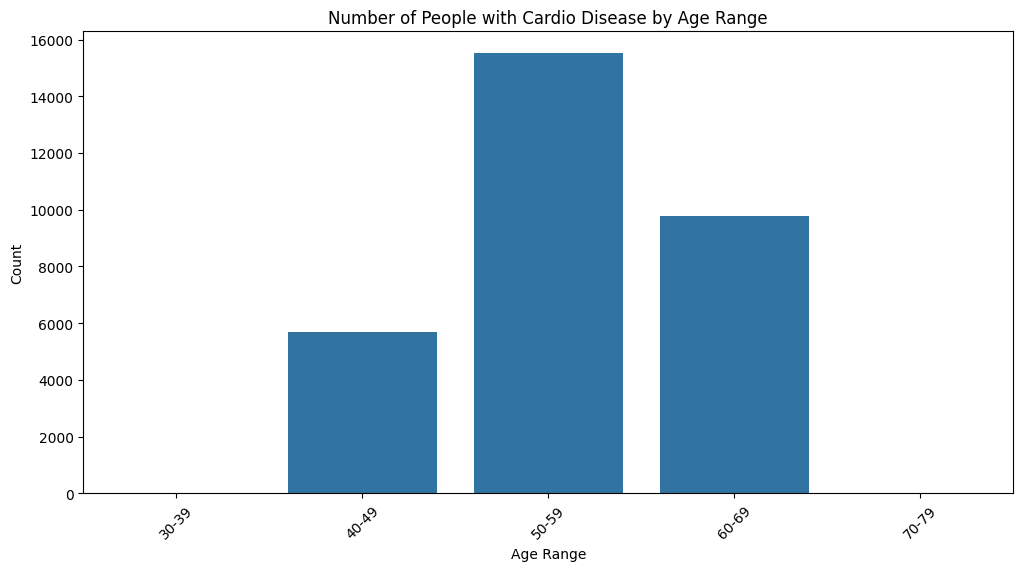

In [26]:
#Countplot to show people having cardio disease by age
age_bins = [30, 40, 50, 60, 70, 80]
age_labels = ['30-39', '40-49', '50-59', '60-69', '70-79']

df['age_range'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

plt.figure(figsize=(12, 6))
sns.countplot(x='age_range', data=df[df['cardio_disease'] == 1], order=age_labels)
plt.title('Number of People with Cardio Disease by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Inference
The countplot divides people into age groups in order to investigate the connection between age and the prevalence of cardiovascular disease. Five age groups are formed as a result: 30–39, 40–49, 50–59, 60–69, and 70–79. The number of individuals with cardiovascular disease within each age range is then represented visually by the countplot.

The figure highlights an interesting trend: as people age, the prevalence of cardiovascular illness rises significantly. The age range of 60–69 has the largest count, closely followed by that of 70–79. This implies that age is a major risk factor for cardiovascular disease, with older people having a higher chance of getting the illness.


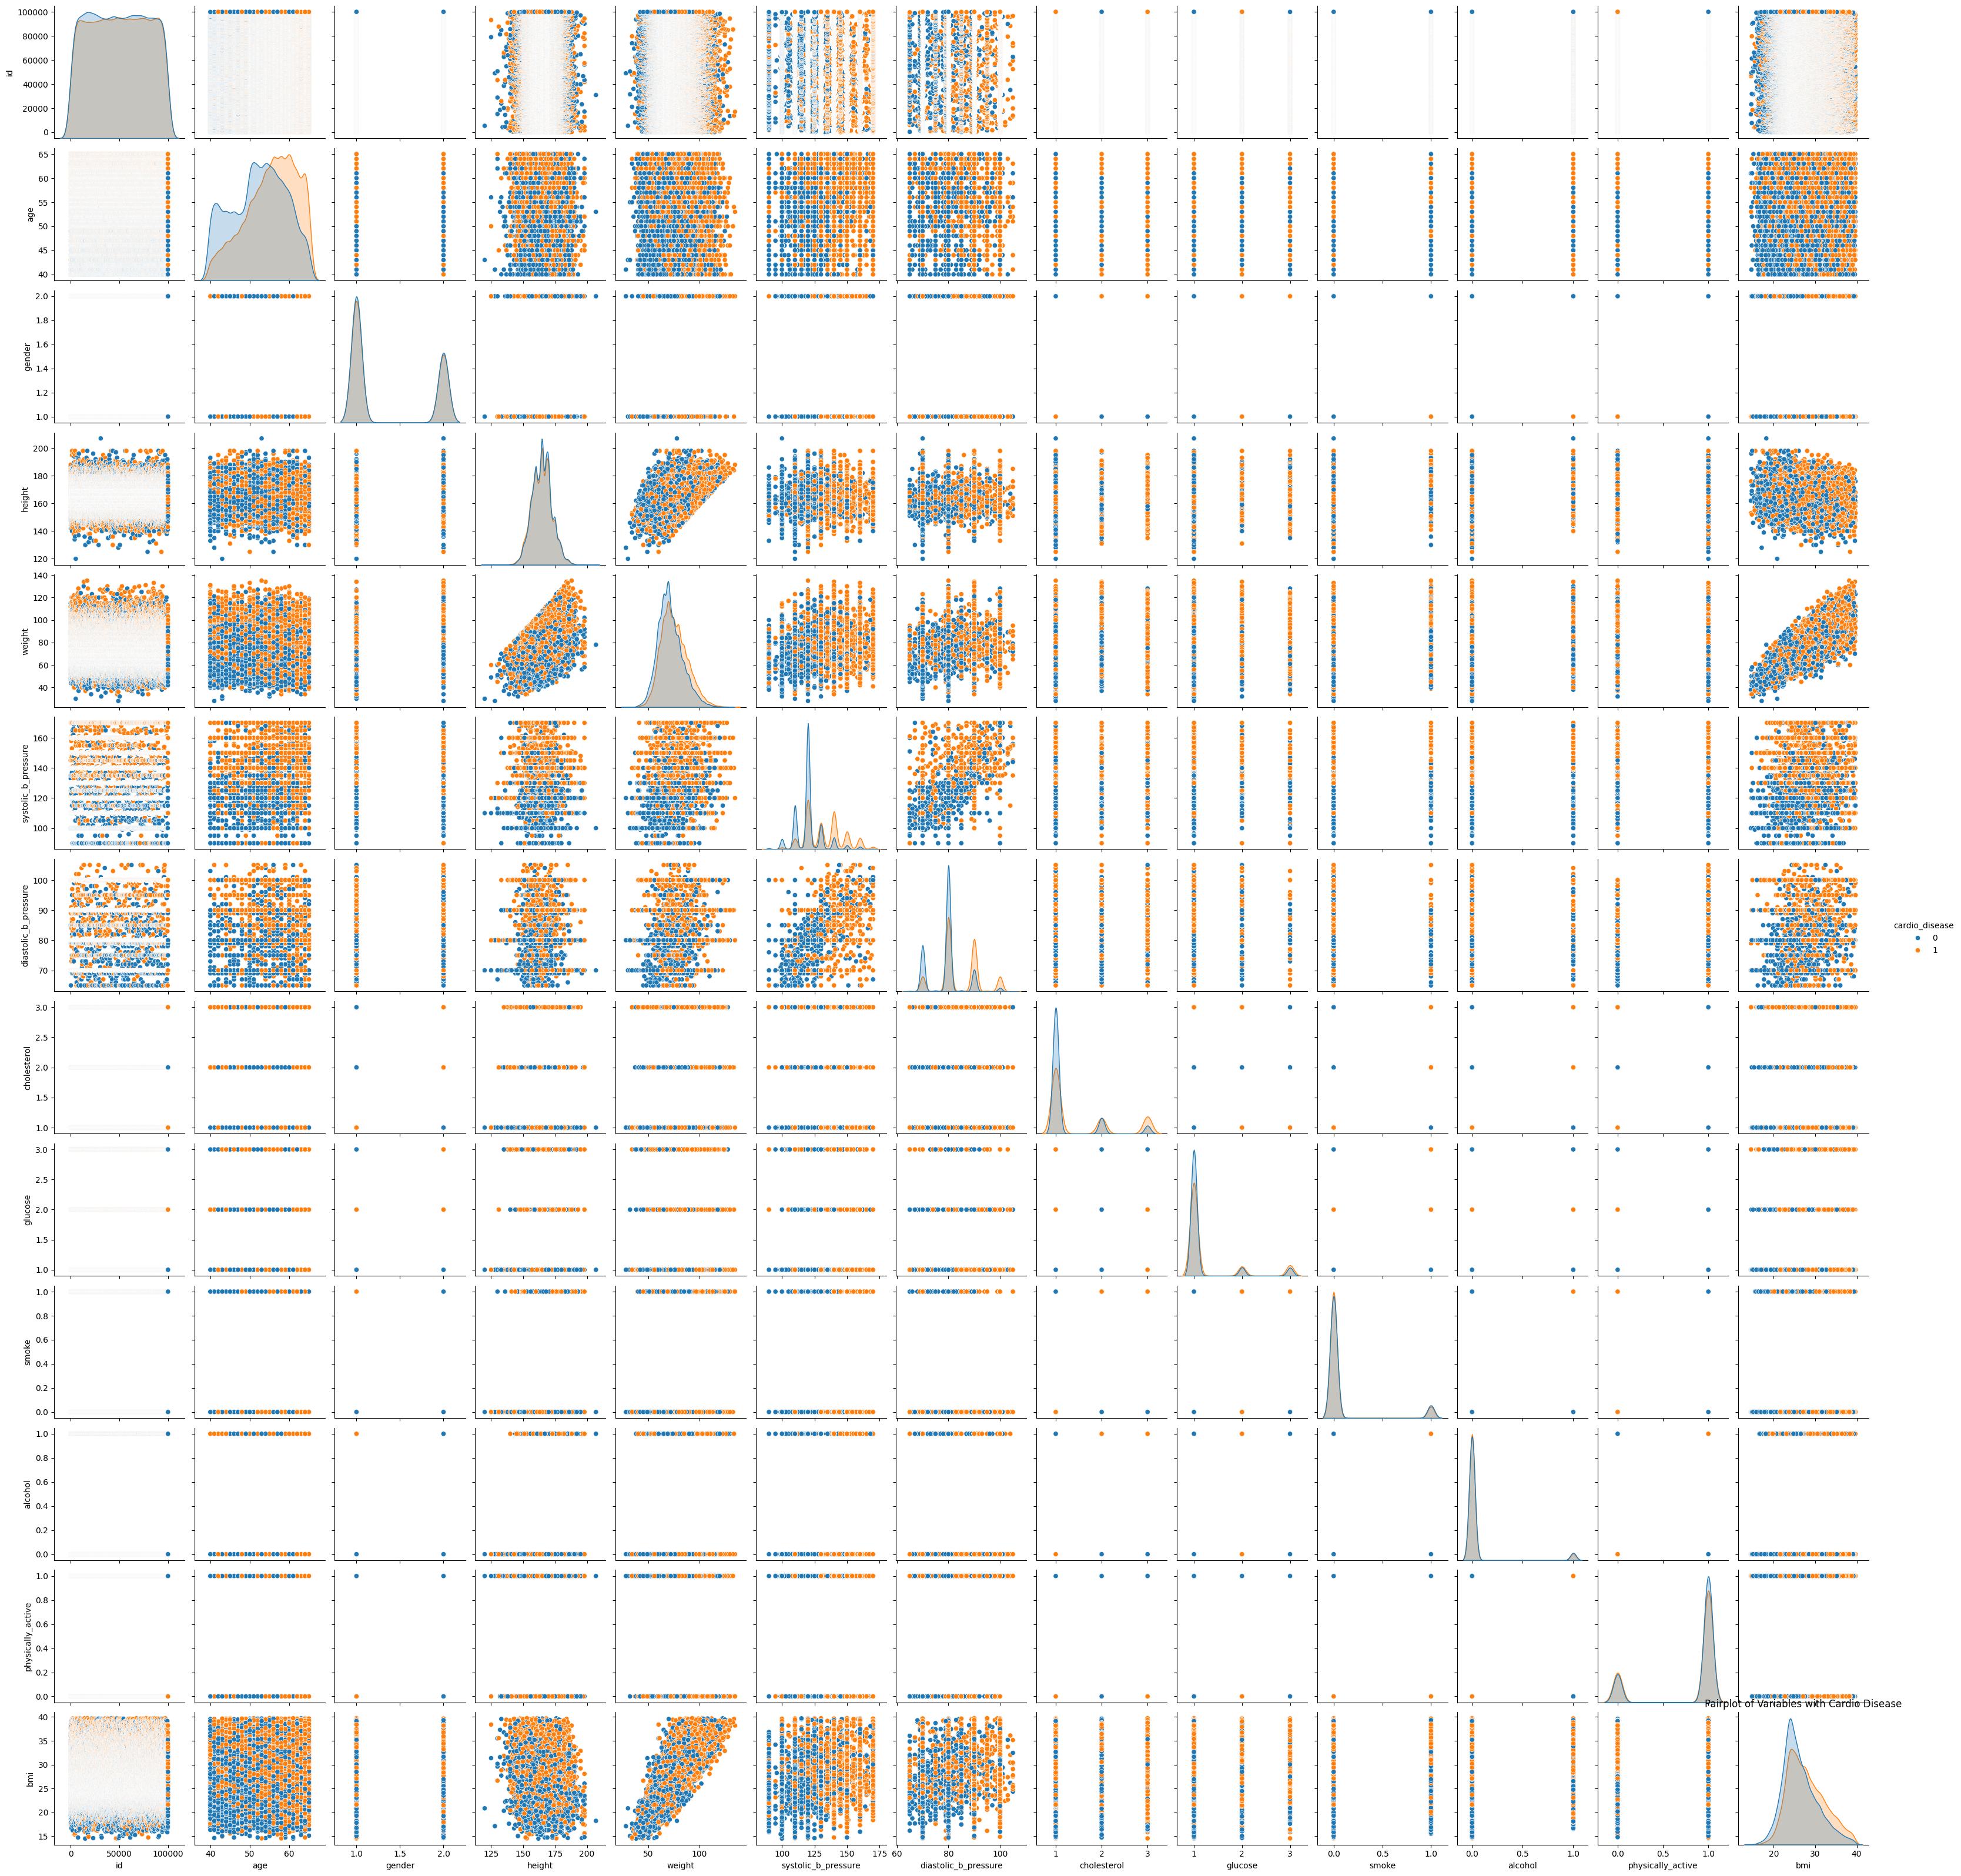

In [ ]:
# Creating by pairplot to explore relationships between variables
sns.pairplot(data = df, hue='cardio_disease')
plt.title('Pairplot of Variables with Cardio Disease')
plt.show()

### Normalization

In [43]:
scaler = MinMaxScaler()

# Select the numerical columns for normalization
numerical_columns = ['age', 'height', 'weight','systolic_b_pressure','diastolic_b_pressure' ]

# Normalize the selected numerical columns
df_normalized = df.copy()  # Create a copy of the original dataframe
df_normalized[numerical_columns] = scaler.fit_transform(df_normalized[numerical_columns])

# Display the normalized dataframe
print(df_normalized.head())

   id   age  gender    height    weight  systolic_b_pressure  \
0   0  0.44       2  0.551724  0.317757                0.250   
1   1  0.64       1  0.413793  0.532710                0.625   
2   2  0.48       1  0.517241  0.336449                0.500   
3   3  0.36       2  0.563218  0.504673                0.750   
5   8  0.80       1  0.356322  0.364486                0.375   

   diastolic_b_pressure  cholesterol  glucose  smoke  alcohol  \
0                 0.375            1        1      0        0   
1                 0.625            3        1      0        0   
2                 0.125            3        1      0        0   
3                 0.875            1        1      0        0   
5                 0.375            2        2      0        0   

   physically_active  cardio_disease        bmi  
0                  1               0  21.967120  
1                  1               1  34.927679  
2                  0               1  23.507805  
3                  1    

### Inference
MinMax scaler is used for normalization, to rescale numerical features within a dataset. It begins by selecting relevant numerical columns. It then creates a copy of the original dataframe to preserve the original data and applies the MinMaxScaler to those selected columns within the copy. This rescales feature values to a common range between 0 and 1. The output shows the transformed values in the first few rows of the normalised dataframe. The fact that values in the numerical columns now range from 0 to 1 shows that normalisation was applied successfully. Columns that aren't numerical, such as gender and cardio_disease, don't change.

### Feature Selection

In [44]:
#Separate features and target variable
X = df.drop(columns=['id', 'cardio_disease'])
y = df['cardio_disease']

In [45]:
#Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Inference
First the features and target variables are separated into X and Y variables. The X variable is the feature and the Y variable is the target, which is the output to be calculated. Once the features are separated we must standardize the features to transform the data so that it has a mean 0 and standard deviation 1.


In [46]:
#Correlation Analysis
correlation_matrix = df.corr()
relevant_features_corr = correlation_matrix['cardio_disease'].abs().sort_values(ascending=False)[1:]
print("Correlation-based relevant features:", relevant_features_corr)

Correlation-based relevant features: systolic_b_pressure     0.432115
diastolic_b_pressure    0.335994
age                     0.234552
cholesterol             0.218286
bmi                     0.179120
weight                  0.159961
glucose                 0.085686
physically_active       0.036023
smoke                   0.018408
height                  0.015556
alcohol                 0.010975
id                      0.005622
gender                  0.002455
Name: cardio_disease, dtype: float64


### Inference
By calculating the correlation coefficient between each feature and the target variable, we can prioritize the most relevant features for predictive modeling. A correlation coefficient close to 1 indicates a strong positive linear relationship, while a coefficient close to -1 indicates a strong negative linear relationship. A coefficient near 0 suggests little to no linear relationship between the variables.


In [47]:
#Univariate Feature Selection
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
relevant_features_univariate = X.columns[selector.get_support()]
print("Univariate feature selection relevant features:", relevant_features_univariate)

Univariate feature selection relevant features: Index(['age', 'gender', 'height', 'weight', 'systolic_b_pressure',
       'diastolic_b_pressure', 'cholesterol', 'glucose', 'smoke', 'alcohol',
       'physically_active', 'bmi'],
      dtype='object')


### Inference
Univariate feature selection evaluates each feature's individual relationship with the target variable to identify the most relevant ones. This technique evaluates each feature independently and selects those that demonstrate the strongest association with the target variable.


In [48]:
#Recursive Feature Elimination (RFE)
estimator = LogisticRegression()
rfe_selector = RFE(estimator, n_features_to_select=5, step=1)
rfe_selector.fit(X, y)
relevant_features_rfe = X.columns[rfe_selector.support_]
print("RFE-based relevant features:", relevant_features_rfe)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

RFE-based relevant features: Index(['cholesterol', 'glucose', 'smoke', 'alcohol', 'physically_active'], dtype='object')


### Inference
Recursive Feature Elimination (RFE) is an iterative feature selection method that uses a machine learning model to identify and eliminate the weakest features. RFE is applied using logistic regression as the estimator to select the top 5 relevant features for predicting cardiovascular disease.

In [49]:
#Tree-based Feature Importance
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
relevant_features_tree_based = feature_importances.sort_values(ascending=False).index[:5]
print("Tree-based feature importance relevant features:", relevant_features_tree_based)

Tree-based feature importance relevant features: Index(['bmi', 'systolic_b_pressure', 'age', 'weight', 'height'], dtype='object')


### Inference
Tree-based feature importance is a technique used in machine learning to determine the importance of each feature in a predictive model, particularly in tree-based algorithms such as Random Forests or Gradient Boosting Machines. This technique assesses the contribution of each feature to the decision-making process within the trees of the ensemble model. Features that are frequently used at the top of decision trees or contribute significantly to reducing impurity or increasing information gain during the tree-building process are assigned higher importance scores.


### Model Implementation

In [50]:
X = df.drop(columns=['id', 'cardio_disease'])
y = df['cardio_disease']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Initialization
logreg_model = LogisticRegression(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)
knn_model = KNeighborsClassifier()

# Model Training
logreg_model.fit(X_train_scaled, y_train)
gbm_model.fit(X_train_scaled, y_train)
knn_model.fit(X_train_scaled, y_train)

# Make Predictions
y_pred_logreg = logreg_model.predict(X_test_scaled)
y_pred_gbm = gbm_model.predict(X_test_scaled)
y_pred_knn = knn_model.predict(X_test_scaled)

### Inference
The dataset is preprocessed by splitting it into features (X) and the target variable (y), where the target variable is 'cardio_disease' and the features exclude the 'id' column and the target variable itself. The data is then split into training and testing sets using an 80-20 split ratio. It splits the data into training and testing sets to ensure model generalization to unseen data. It standardizes features using StandardScaler, placing them on a common scale for better model performance. Each model is trained on the training data using the fit method, where the features are scaled using the scaled training data (X_train_scaled) and the corresponding target variable (y_train).


In [51]:
# Evaluating the metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Gradient Boosting Machine Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("k-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn))

Logistic Regression Accuracy: 0.7257948840545063
Gradient Boosting Machine Accuracy: 0.7318511435174118
k-Nearest Neighbors Accuracy: 0.6849151326798948


In [52]:
# Evaluation metrics
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("\nGradient Boosting Machine Classification Report:")
print(classification_report(y_test, y_pred_gbm))

print("\nk-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6393
           1       0.75      0.66      0.70      6156

    accuracy                           0.73     12549
   macro avg       0.73      0.72      0.72     12549
weighted avg       0.73      0.73      0.72     12549


Gradient Boosting Machine Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6393
           1       0.75      0.68      0.71      6156

    accuracy                           0.73     12549
   macro avg       0.73      0.73      0.73     12549
weighted avg       0.73      0.73      0.73     12549


k-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      6393
           1       0.68      0.67      0.68      6156

    accuracy                           0.68 

### Hyperparameter Tuning

In [53]:
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', None]  # Updated to use None instead of 'none'
}


logreg_model = LogisticRegression(random_state=42)
logreg_grid_search = GridSearchCV(estimator=logreg_model, param_grid=logreg_param_grid, cv=5)
logreg_grid_search.fit(X_train_scaled, y_train)

# Gradient Boosting
gbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

gbm_model = GradientBoostingClassifier(random_state=42)
gbm_grid_search = GridSearchCV(estimator=gbm_model, param_grid=gbm_param_grid, cv=5)
gbm_grid_search.fit(X_train_scaled, y_train)

# k-Nearest Neighbors
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(estimator=knn_model, param_grid=knn_param_grid, cv=5)
knn_grid_search.fit(X_train_scaled, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']})

### Inference
This process aims to improve the model's performance, generalization ability, and robustness to unseen data.

Grid Search: Exhaustively searching through a specified subset of hyperparameter combinations.


In [54]:
print("Logistic Regression - Best Parameters:", logreg_grid_search.best_params_)
print("Logistic Regression - Best Score:", logreg_grid_search.best_score_)

print("Gradient Boosting - Best Parameters:", gbm_grid_search.best_params_)
print("Gradient Boosting - Best Score:", gbm_grid_search.best_score_)

print("k-Nearest Neighbors - Best Parameters:", knn_grid_search.best_params_)
print("k-Nearest Neighbors - Best Score:", knn_grid_search.best_score_)

Logistic Regression - Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Logistic Regression - Best Score: 0.7220097952646035
Gradient Boosting - Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Gradient Boosting - Best Score: 0.7295601576163719
k-Nearest Neighbors - Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}
k-Nearest Neighbors - Best Score: 0.7053749936998692


In [55]:
best_logreg_model = logreg_grid_search.best_estimator_
best_gbm_model = gbm_grid_search.best_estimator_
best_knn_model = knn_grid_search.best_estimator_

# Make predictions on the test set
y_pred_logreg = best_logreg_model.predict(X_test_scaled)
y_pred_gbm = best_gbm_model.predict(X_test_scaled)
y_pred_knn = best_knn_model.predict(X_test_scaled)

# Calculate accuracy for each model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Print accuracy for each model
print("Accuracy for Logistic Regression:", accuracy_logreg)
print("Accuracy for Gradient Boosting:", accuracy_gbm)
print("Accuracy for k-Nearest Neighbors:", accuracy_knn)

Accuracy for Logistic Regression: 0.7256355088054826
Accuracy for Gradient Boosting: 0.7300183281536378
Accuracy for k-Nearest Neighbors: 0.70220734719898


In [56]:
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("\nGradient Boosting Machine Classification Report:")
print(classification_report(y_test, y_pred_gbm))

print("\nk-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6393
           1       0.75      0.66      0.70      6156

    accuracy                           0.73     12549
   macro avg       0.73      0.72      0.72     12549
weighted avg       0.73      0.73      0.72     12549


Gradient Boosting Machine Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      6393
           1       0.74      0.68      0.71      6156

    accuracy                           0.73     12549
   macro avg       0.73      0.73      0.73     12549
weighted avg       0.73      0.73      0.73     12549


k-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      6393
           1       0.71      0.67      0.69      6156

    accuracy                           0.70 

In [57]:
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

# Evaluate Logistic Regression model
print("Logistic Regression Performance:")
evaluate_model(best_logreg_model, X_test_scaled, y_test)
print()

# Evaluate Gradient Boosting model
print("Gradient Boosting Performance:")
evaluate_model(best_gbm_model, X_test_scaled, y_test)
print()

# Evaluate k-Nearest Neighbors model
print("k-Nearest Neighbors Performance:")
evaluate_model(best_knn_model, X_test_scaled, y_test)

Logistic Regression Performance:
Accuracy: 0.7256355088054826
Precision: 0.7525600446844163
Recall: 0.656595191682911
F1-score: 0.7013099679014488

Gradient Boosting Performance:
Accuracy: 0.7300183281536378
Precision: 0.7447824548991864
Recall: 0.6840480831708902
F1-score: 0.7131244707874682

k-Nearest Neighbors Performance:
Accuracy: 0.70220734719898
Precision: 0.7056623023295358
Recall: 0.6741390513320338
F1-score: 0.6895405832017946


In [58]:
# Function to evaluate model performance including ROC-AUC
def evaluate_model_roc_auc(model, X_test, y_test):
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print ROC-AUC score
    print("ROC-AUC:", roc_auc)

# Evaluate Logistic Regression model
print("Logistic Regression Performance:")
evaluate_model_roc_auc(best_logreg_model, X_test_scaled, y_test)
print()

# Evaluate Gradient Boosting model
print("Gradient Boosting Performance:")
evaluate_model_roc_auc(best_gbm_model, X_test_scaled, y_test)
print()

# Evaluate k-Nearest Neighbors model
print("k-Nearest Neighbors Performance:")
evaluate_model_roc_auc(best_knn_model, X_test_scaled, y_test)

Logistic Regression Performance:
ROC-AUC: 0.7893098181317753

Gradient Boosting Performance:
ROC-AUC: 0.7963690056751683

k-Nearest Neighbors Performance:
ROC-AUC: 0.7539084054430472


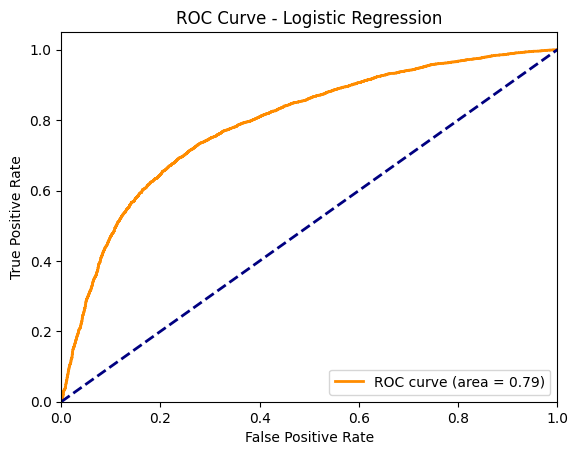

In [71]:
# Function to plot ROC curve and calculate AUC
def plot_roc_auc(model, X_test, y_test, model_name):
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for Logistic Regression
plot_roc_auc(best_logreg_model, X_test_scaled, y_test, "Logistic Regression")

### Inference
Logistic Regression achieved a ROC-AUC score of approximately 0.789, indicating its ability to discriminate between positive and negative cases with a reasonable degree of accuracy.


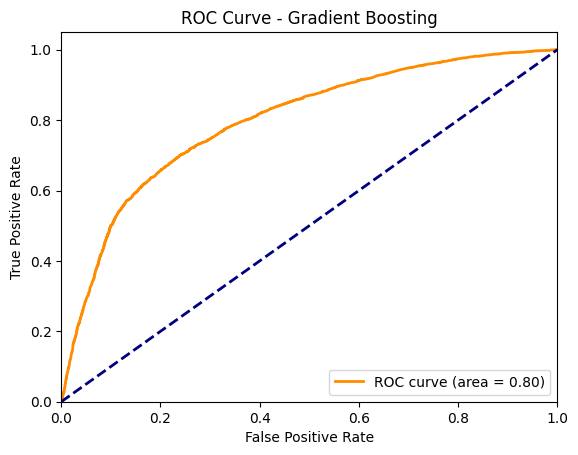

In [69]:
# Plot ROC curve for Gradient Boosting
plot_roc_auc(best_gbm_model, X_test_scaled, y_test, "Gradient Boosting")

### Inference
Gradient Boosting exhibited a slightly higher ROC-AUC score of 0.796, implying that it may offer slightly better discrimination between positive and negative cases compared to Logistic Regression. This suggests that Gradient Boosting's ensemble learning approach may provide enhanced predictive performance.


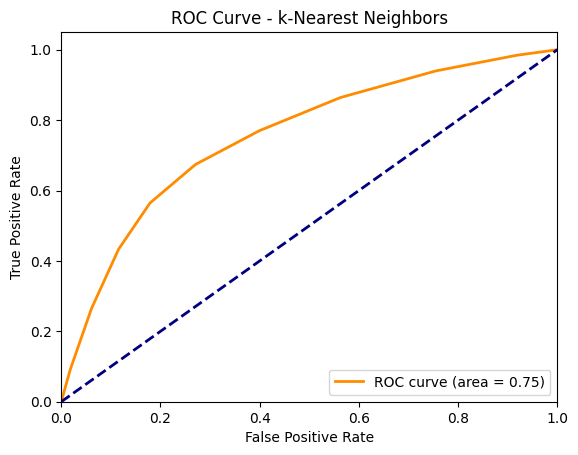

In [70]:
# Plot ROC curve for k-Nearest Neighbors
plot_roc_auc(best_knn_model, X_test_scaled, y_test, "k-Nearest Neighbors")

### Inference
k-Nearest Neighbors achieved a ROC-AUC score of 0.754, indicating its moderate ability to discriminate between positive and negative cases. It suggests that k-Nearest Neighbors may not be as effective in distinguishing between individuals at varying levels compared to Logistic Regression and Gradient Boosting.


In [72]:
from sklearn.metrics import confusion_matrix

# Function to evaluate model performance with confusion matrix
def evaluate_with_confusion_matrix(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

# Evaluate Logistic Regression model with confusion matrix
print("Logistic Regression Performance with Confusion Matrix:")
evaluate_with_confusion_matrix(logreg_grid_search.best_estimator_, X_test_scaled, y_test)
print()

# Evaluate Gradient Boosting model with confusion matrix
print("Gradient Boosting Performance with Confusion Matrix:")
evaluate_with_confusion_matrix(gbm_grid_search.best_estimator_, X_test_scaled, y_test)
print()

# Evaluate k-Nearest Neighbors model with confusion matrix
print("k-Nearest Neighbors Performance with Confusion Matrix:")
evaluate_with_confusion_matrix(knn_grid_search.best_estimator_, X_test_scaled, y_test)


Logistic Regression Performance with Confusion Matrix:
Confusion Matrix:
[[5064 1329]
 [2114 4042]]

Gradient Boosting Performance with Confusion Matrix:
Confusion Matrix:
[[4950 1443]
 [1945 4211]]

k-Nearest Neighbors Performance with Confusion Matrix:
Confusion Matrix:
[[4662 1731]
 [2006 4150]]


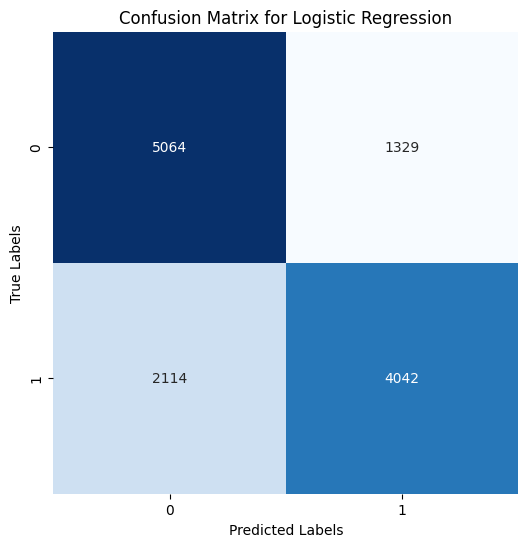

In [73]:
# Function to visualize confusion matrix
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Visualize confusion matrix for Logistic Regression
plot_confusion_matrix(logreg_grid_search.best_estimator_, X_test_scaled, y_test, "Logistic Regression")

### Inference
For Logistic Regression, the confusion matrix reveals that out of a total of 6393 instances predicted as negative, 5064 were correctly classified, while 1329 were falsely predicted as positive. Conversely, out of 6156 instances predicted as positive, 4042 were correctly classified, and 2114 were falsely predicted as negative.


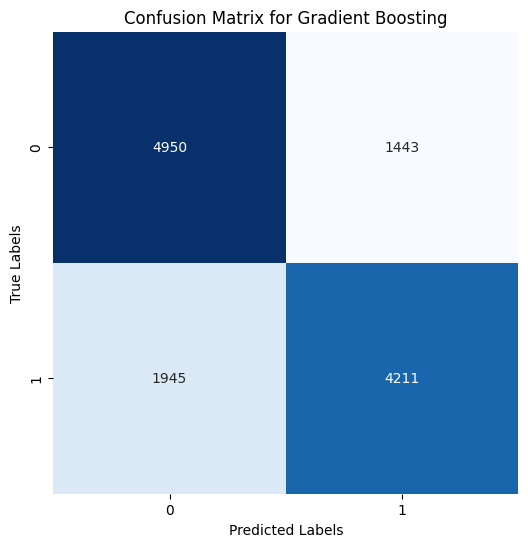

In [74]:
#Visualize confusion matrix for Gradient Boosting
plot_confusion_matrix(gbm_grid_search.best_estimator_, X_test_scaled, y_test, "Gradient Boosting")


### Inference
The confusion matrix for Gradient Boosting illustrates similar performance trends. Among 6393 instances predicted as negative, 4950 were correctly classified, with 1443 falsely predicted as positive. Additionally, out of 6156 instances predicted as positive, 4211 were correctly classified, and 1945 were falsely predicted as negative.


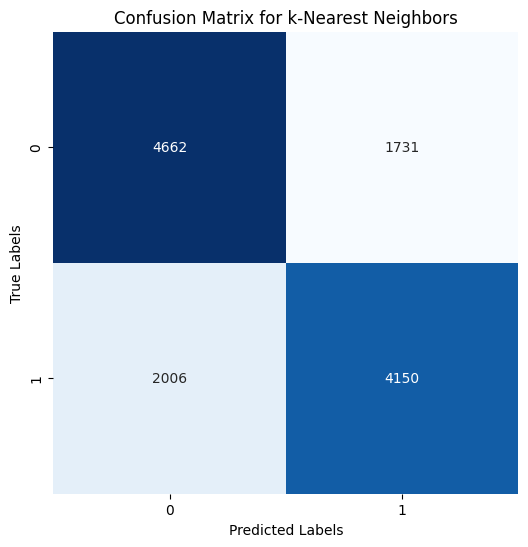

In [75]:
# Visualize confusion matrix for k-Nearest Neighbors
plot_confusion_matrix(knn_grid_search.best_estimator_, X_test_scaled, y_test, "k-Nearest Neighbors")

### Inference
For k-Nearest Neighbors, the confusion matrix demonstrates the model's performance. Among 6393 instances predicted as negative, 4662 were correctly classified, while 1731 were falsely predicted as positive. Moreover, out of 6156 instances predicted as positive, 4150 were correctly classified, and 2006 were falsely predicted as negative.


# Conclusion

From the comparative analysis of the three algorithms - Logistic Regression, Gradient Boosting, and k-Nearest Neighbors (k-NN) - before and after hyperparameter tuning, we observed several insights and findings:

### Accuracy and Classification Reports:

-> Before hyperparameter tuning, Gradient Boosting showed the highest accuracy among the three algorithms, followed closely by Logistic Regression, and then k-NN.

-> After hyperparameter tuning, Gradient Boosting still maintained the highest accuracy, while both Logistic Regression and k-NN showed slight improvements in their accuracy scores.

-> In terms of precision, recall, and F1-score, Gradient Boosting consistently showed competitive performance across both scenarios, with relatively balanced results for both classes (0 and 1).

-> Logistic Regression and k-NN also exhibited decent performance, but their precision, recall, and F1-score for class 1 were slightly lower compared to Gradient Boosting.

### ROC-AUC:

-> After hyperparameter tuning, all three algorithms showed robust ROC-AUC scores, indicating their ability to discriminate between positive and negative classes effectively.

-> Gradient Boosting had the highest ROC-AUC score, followed by Logistic Regression and k-NN, implying that Gradient Boosting had the best overall performance in terms of class separation.

### Confusion Matrix:

-> When examining the confusion matrices, we found that Gradient Boosting had the best balance between true positives, true negatives, false positives, and false negatives, indicating its effectiveness in predicting both classes accurately.

-> Logistic Regression and k-NN also performed reasonably well, but they showed a relatively higher number of false negatives and false positives compared to Gradient Boosting.

### Computational Efficiency and Applicability:

-> Logistic Regression is computationally efficient and suitable for linearly separable data. It's interpretable and works well for binary classification problems like the one in this dataset.

-> Gradient Boosting, while more computationally intensive, is powerful for handling complex, nonlinear relationships in data. It's less interpretable but generally provides high predictive accuracy.

-> k-NN is a simple and intuitive algorithm, but it can be computationally expensive, especially with large datasets. It's suitable for smaller datasets and works well when instances of the same class are close together in the feature space.


#### Based on these findings, the recommendation for the most suitable algorithm depends on the specific requirements of the problem:

-> If computational efficiency and interpretability are important, Logistic Regression would be a good choice, especially if the data is linearly separable.

-> If high predictive accuracy is paramount and computational resources permit, Gradient Boosting would be the preferred option due to its robust performance in handling complex relationships in data.

->k-NN can be a suitable choice for smaller datasets with well-separated classes, but it may not scale well to larger datasets due to its computational overhead.




